Travail developpe par le binome :
**Bruno OLIVEIRA, Samuel GHEZI**

Sur orientation de le Professeur **Martin GHIENNE**.

**Introduction**

L’exploitation d’un avion s’accompagne de conditions de vol très variables et difficiles à prédire, ce qui rend complexe l’estimation précise des chargements structuraux rencontrés en situation réelle. Bien que des informations telles que les déformations et les contraintes soient essentielles pour optimiser la maintenance et améliorer les modèles de dimensionnement, ces grandeurs ne sont généralement pas mesurées directement sur les aéronefs commerciaux. L’installation de capteurs dédiés entraînerait en effet une augmentation significative des coûts, de la masse, de la complexité d’intégration et des exigences de certification.

Le Mini-Challenge propose ainsi de développer un capteur virtuel basé sur des méthodes d’apprentissage automatique, capable d’estimer l’état de contrainte structurelle en différents points de l’avion à partir des seuls paramètres déjà enregistrés par l’instrumentation de bord. L’objectif est de prédire des grandeurs non mesurées physiquement, mais inférées à partir de variables de vol telles que l’attitude, les vitesses, les accélérations, les ordres de commande et les conditions de vent.

Pour cela, un ensemble de données réelles provenant de 44 vols d’essai est mis à disposition. Ce jeu de données comprend :

39 paramètres issus de l’instrumentation de bord, représentant l’état de vol, les efforts aérodynamiques et les actions de contrôle ;

15 jauges d’extensométrie (en micro-déformations, με) positionnées en différents points structuraux de l’appareil, permettant de mesurer directement les contraintes locales.

En résumé, ce projet vise à démontrer la capacité d’un modèle d’apprentissage supervisé à reproduire les contraintes structurelles réelles à partir de données opérationnelles courantes, ouvrant la voie à des stratégies de maintenance plus prédictives, moins coûteuses et mieux informées, dans la continuité des travaux précédents sur les capteurs virtuels pour le suivi de santé structurale.

Pour cette projet, on va se baser dans la teorie de Machine Learning, en se basent dans l'image ci dessous :

**Management des données**

Le liste de variable avec les description et sont format qui existe dans les données collectées pendant les vols sont en dessous :

In [1]:
# Importing Lybraries
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.nn.init import kaiming_uniform_

**Management des données** - Acquisition des données

Displayng the dataframes

**Management des données** - Exploration des Données

Ploting grqphs for correlation

**Management des données** - Préparation des Données

In [2]:
df = pd.read_csv('df.csv')

In [3]:
df = df.drop(columns='Relative_Time')

In [4]:
df.head(5)

,Nz,Nx,Roll_Angle,Pitch_Angle,True_AOA,True_Sideslip,FPA,True_Heading,CAS,TAS,...,Strain7,Strain8,Strain9,Strain10,Strain11,Strain12,Strain13,Strain14,Strain15,Tol_ID
0,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.823861,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TOL_1
1,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.823861,0.0,0.0,...,-0.601572,-0.884219,-0.463841,0.161175,-0.000325,-0.143096,0.403351,0.006286,0.175358,TOL_1
2,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.824664,0.0,0.0,...,-0.310433,-1.410038,-1.853289,0.646155,-0.000651,-0.571435,0.818918,0.012573,0.350715,TOL_1
3,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,0.424748,-1.414549,-1.854326,0.174219,-0.000976,-1.013577,1.216162,-1.045466,-0.521183,TOL_1
4,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,0.572497,-2.114138,2.512348,0.644700,0.579980,-0.572384,1.613406,0.691031,0.003260,TOL_1


In [5]:
# Targets = deformações (saídas do modelo)
target_cols = [f"Strain{i}" for i in range(1, 16)]

# Features = todas as colunas menos Strains e Flight_ID
feature_cols = [c for c in df.columns if c not in target_cols + ["Tol_ID"]]

print("Features:", feature_cols)
print("Targets :", target_cols)

Features: ['Nz', 'Nx', 'Roll_Angle', 'Pitch_Angle', 'True_AOA', 'True_Sideslip', 'FPA', 'True_Heading', 'CAS', 'TAS', 'Mach', 'SAT', 'Baro_Alt', 'Roll_Rate', 'Pitch_Rate', 'Heading_Rate', 'Fuel_Qty1', 'Fuel_Qty2', 'L_Eng_Start', 'R_Eng_Start', 'L_Throttle_Pos', 'R_Throttle_Pos', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2', 'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_Flaperon_Pos', 'R_Flaperon_Pos', 'L_LEF_Pos', 'R_LEF_Pos', 'L_Rudder_Pos', 'L_Stab_Pos', 'R_Stab_Pos', 'Stick_Pitch', 'Stick_Roll', 'Pedal_Pos']
Targets : ['Strain1', 'Strain2', 'Strain3', 'Strain4', 'Strain5', 'Strain6', 'Strain7', 'Strain8', 'Strain9', 'Strain10', 'Strain11', 'Strain12', 'Strain13', 'Strain14', 'Strain15']


In [6]:
# Remove linhas com NaN nas colunas importantes
df_clean = df.dropna(subset=feature_cols + target_cols)

X = df_clean[feature_cols].values      # entradas
y = df_clean[target_cols].values      # saídas (strains)
Tol_ids = df_clean["Tol_ID"].values  # de qual TOL é cada linha

In [7]:

X_train, X_temp, y_train, y_temp, ids_train, ids_temp = train_test_split(
    X, y, Tol_ids,
    test_size=0.3,
    random_state=42,
    stratify=Tol_ids
)

X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
    X_temp, y_temp, ids_temp,
    test_size=0.5,
    random_state=42,
    stratify=ids_temp
)

In [8]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

In [9]:
class StrainDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len + 1

    def __getitem__(self, idx):
        x_seq = self.X[idx : idx + self.seq_len]
        y_seq = self.y[idx : idx + self.seq_len]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)
sequence_len1 = 20
train_ds = StrainDataset(X_train_scaled, y_train_scaled, sequence_len1)
val_ds   = StrainDataset(X_val_scaled,   y_val_scaled, sequence_len1)
test_ds  = StrainDataset(X_test_scaled,  y_test_scaled, sequence_len1)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

Notre problème est dynamique car différentes variables dépendent du temps. Comme les variables sont nombreuses il serait aussi intéressant de réduire nos nombres de variables pour caractériser au mieux dans un minimum de variable notre problème. Ainsi, la solution choisit serait un `Multi-modèle` :
- En premier lieu, nous allons réduire nos variables en un espace latent z avec un `Encodeur` qui caractérise au mieux "spatialement" notre problème.
- Nous souhaitons aussi avoir des "fenêtres temporelles d'informations" afin de relier certaine grandeur physiques au temps. Ainsi, la seconde "couche" de notre modèle seront des couches `LSTM` qui relie nos informations au temps, et qui rend un tenseur avec les derniers état caché de chaque cellule.
- Finalement, nos informations passe par des dernières couches d'un `MLP` linéaire standard qui permettent la prédiction des contraintes appliquée à notre avion.

***Encoder layers***

In [ ]:
class Encoder(nn.Module):#réduction de nos variable en un espace latent z qui caractérise au mieux nos données.
    def __init__(self, input_size, z_dim):
        super().__init__() #on appelle la classe parent Module
        self.hidden1 = nn.Linear(input_size, 64)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.hidden2 = nn.Linear(64, 32)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.hidden3 = nn.Linear(32, z_dim)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.relu = nn.ReLU() #la fonction reLU a le gradiant le plus stable, elle semble donc être un bon choix pour notre projet.
    def forward (self, x): #passage du tenseur dans les différentes couches de notre Encoder
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.hidden3(x)
        # x = self.relu(x)
        return x
        

***LSTM Layers***

In [11]:
class Lstm(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, nb_layers: int, dropout: float = 0.1):
        """
            on initialise notre système avec un dropout faible
        """
        super().__init__()
        self.input_size = input_size # récupère la taille des vecteurs des valeurs d'entrées
        self.hidden_size = hidden_size  # récupère le nombre de cellules par couche de lstm
        self.nb_layers = nb_layers  # récupère le nombre de couche dans le LSTM
        # Défini les couches LSTM
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=nb_layers, batch_first=True, dropout=dropout)

    def forward(self, x):
        # on fait passer l'entrée par les différente cellules du lstm
        output, (h_n, c_n) = self.lstm(x)
        return output
    

***MLP predictive layers***

In [ ]:
class MLP_v2(nn.Module):
    def __init__(self, input_size, n_contraintes):
        super().__init__()
        self.hidden1 = nn.Linear(input_size, 256)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.hidden2 = nn.Linear(256, 128)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.hidden3 = nn.Linear(128, n_contraintes)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.hidden3(x)
        return x
        

**Multi-modèle**

In [15]:
class Mercosur(nn.Module):
    def __init__(self, input_size, z_dim, hidden_size, nb_layers, n_contraintes):
        super().__init__()
        self.encoder_layers = Encoder(input_size, z_dim)
        self.lstm_layers = Lstm(z_dim, hidden_size, nb_layers)
        # self.mlp_layers = MLP(hidden_size, n_contraintes).
        self.mlp_layers = MLP_v2(hidden_size, n_contraintes)


    def forward(self, x):
        # x: (batch, seq_len, n_features)
        z_seq = self.encoder_layers(x)      # (batch, seq_len, z_dim)
        h_seq = self.lstm_layers(z_seq)     # (batch, seq_len, hidden_size)
        y_pred = self.mlp_layers(h_seq)     # (batch, seq_len, n_contraintes)
        return y_pred

On instancie nos hyperparamètres qui pourront être optimisé par la suite

In [16]:
hidden_size1 = 64 # le réseau traite beaucoup d'informations et ce sur une séquence de temps qui multiplie les liens entre eux. il faut donc un nombre de cellule dans le lstm équivalent
#le nombre d'entrée du MLP qui servira 
n_features = X_train_scaled.shape[-1]
n_outputs  = y_train_scaled.shape[-1]
z_dim = 16
nb_layers_lstm = 3

In [17]:
print(n_outputs)

15


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
capteur_model = Mercosur(n_features, z_dim, hidden_size1, nb_layers_lstm, n_outputs).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(capteur_model.parameters(), lr=1e-3)

/à lancer

In [20]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(tqdm(loader)):
        # ver o shape só no primeiro batch
        if i == 0:
            print("X_batch shape:", X_batch.shape)
            print("y_batch shape:", y_batch.shape)

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(loader):

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)


In [21]:
print({next(iter(train_loader))[0].shape})

{torch.Size([256, 20, 39])}


In [23]:
import torch
import time

n_epochs   = 30            # máximo absoluto
patience   = 3             # quantas épocas ruins seguidas até parar
best_val   = float("inf")
patience_counter = 0

train_losses, val_losses = [], []
best_model_path = "best_mercosur.pth"

for epoch in range(n_epochs):
    start = time.time()

    train_loss = train_epoch(capteur_model, train_loader, optimizer, criterion)
    val_loss   = eval_epoch(capteur_model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    epoch_time = time.time() - start
    print(f"Epoch {epoch+1:03d} | {epoch_time:.1f}s | Train: {train_loss:.6f} | Val: {val_loss:.6f}")

    # melhorou? salva modelo e zera paciência
    if val_loss < best_val:
        best_val = val_loss
        patience_counter = 0
        torch.save(capteur_model.state_dict(), best_model_path)
        print(f"  Better model saved in (val_loss = {best_val:.6f})")
    else:
        patience_counter += 1
        print(f" (no improvement for {patience_counter} épocas)")

    # se não melhora há X épocas, para
    if patience_counter >= patience:
        print(f" Early stopping in epochs {epoch+1}. Melhor val_loss = {best_val:.6f}")
        break


  0%|          | 0/19303 [00:00<?, ?it/s]

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:11<00:00, 100.94it/s]


Epoch 001 | 224.3s | Train: 0.190224 | Val: 0.140672
  Better model saved in (val_loss = 0.140672)


  0%|          | 6/19303 [00:00<17:55, 17.94it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:04<00:00, 104.52it/s]


Epoch 002 | 214.1s | Train: 0.125135 | Val: 0.103417
  Better model saved in (val_loss = 0.103417)


  0%|          | 8/19303 [00:00<13:16, 24.24it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:07<00:00, 102.77it/s]


Epoch 003 | 216.6s | Train: 0.103884 | Val: 0.086910
  Better model saved in (val_loss = 0.086910)


  0%|          | 7/19303 [00:00<14:29, 22.19it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:08<00:00, 102.62it/s]


Epoch 004 | 217.5s | Train: 0.092470 | Val: 0.080229
  Better model saved in (val_loss = 0.080229)


  0%|          | 7/19303 [00:00<14:49, 21.69it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:09<00:00, 101.67it/s]


Epoch 005 | 220.2s | Train: 0.085805 | Val: 0.074751
  Better model saved in (val_loss = 0.074751)


  0%|          | 7/19303 [00:00<14:48, 21.71it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:04<00:00, 104.86it/s]


Epoch 006 | 213.2s | Train: 0.081463 | Val: 0.065457
  Better model saved in (val_loss = 0.065457)


  0%|          | 7/19303 [00:00<14:45, 21.80it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:03<00:00, 105.18it/s]


Epoch 007 | 213.0s | Train: 0.078399 | Val: 0.062249
  Better model saved in (val_loss = 0.062249)


  0%|          | 13/19303 [00:00<09:15, 34.70it/s] 

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:06<00:00, 103.24it/s]


Epoch 008 | 216.1s | Train: 0.076031 | Val: 0.060267
  Better model saved in (val_loss = 0.060267)


  0%|          | 8/19303 [00:00<13:21, 24.07it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:02<00:00, 105.77it/s]


Epoch 009 | 212.7s | Train: 0.074203 | Val: 0.058840
  Better model saved in (val_loss = 0.058840)


  0%|          | 8/19303 [00:00<12:46, 25.18it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:05<00:00, 104.02it/s]


Epoch 010 | 215.3s | Train: 0.072751 | Val: 0.057276
  Better model saved in (val_loss = 0.057276)


  0%|          | 7/19303 [00:00<15:12, 21.15it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:05<00:00, 103.85it/s]


Epoch 011 | 215.0s | Train: 0.071560 | Val: 0.057932
 (no improvement for 1 épocas)


  0%|          | 15/19303 [00:00<07:58, 40.29it/s] 

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:01<00:00, 106.35it/s]


Epoch 012 | 210.7s | Train: 0.070508 | Val: 0.062552
 (no improvement for 2 épocas)


  0%|          | 6/19303 [00:00<17:10, 18.72it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:02<00:00, 105.76it/s]


Epoch 013 | 211.0s | Train: 0.069678 | Val: 0.057049
  Better model saved in (val_loss = 0.057049)


  0%|          | 8/19303 [00:00<12:07, 26.52it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:06<00:00, 103.40it/s]


Epoch 014 | 215.5s | Train: 0.068897 | Val: 0.053979
  Better model saved in (val_loss = 0.053979)


  0%|          | 6/19303 [00:00<16:36, 19.36it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:34<00:00, 89.82it/s]


Epoch 015 | 251.8s | Train: 0.068235 | Val: 0.051992
  Better model saved in (val_loss = 0.051992)


  0%|          | 10/19303 [00:00<11:20, 28.34it/s] 

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:44<00:00, 86.11it/s] 


Epoch 016 | 258.9s | Train: 0.067663 | Val: 0.052229
 (no improvement for 1 épocas)


  0%|          | 6/19303 [00:00<18:23, 17.48it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:38<00:00, 88.39it/s]


Epoch 017 | 254.7s | Train: 0.067097 | Val: 0.052761
 (no improvement for 2 épocas)


  0%|          | 8/19303 [00:00<13:53, 23.16it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:22<00:00, 95.13it/s] 


Epoch 018 | 232.1s | Train: 0.066567 | Val: 0.051207
  Better model saved in (val_loss = 0.051207)


  0%|          | 6/19303 [00:00<17:01, 18.89it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:03<00:00, 105.47it/s]


Epoch 019 | 212.8s | Train: 0.066106 | Val: 0.053890
 (no improvement for 1 épocas)


  0%|          | 8/19303 [00:00<12:49, 25.09it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:05<00:00, 104.21it/s]


Epoch 020 | 214.2s | Train: 0.065716 | Val: 0.049753
  Better model saved in (val_loss = 0.049753)


  0%|          | 7/19303 [00:00<14:34, 22.06it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:04<00:00, 104.85it/s]


Epoch 021 | 213.7s | Train: 0.065320 | Val: 0.048891
  Better model saved in (val_loss = 0.048891)


  0%|          | 21/19303 [00:00<05:41, 56.39it/s] 

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:02<00:00, 105.74it/s]


Epoch 022 | 211.7s | Train: 0.064958 | Val: 0.049003
 (no improvement for 1 épocas)


  0%|          | 6/19303 [00:00<17:46, 18.10it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:06<00:00, 103.46it/s]


Epoch 023 | 215.8s | Train: 0.064680 | Val: 0.051158
 (no improvement for 2 épocas)


  0%|          | 8/19303 [00:00<12:30, 25.71it/s]  

X_batch shape: torch.Size([256, 20, 39])
y_batch shape: torch.Size([256, 20, 15])


100%|██████████| 19303/19303 [03:02<00:00, 105.87it/s]


Epoch 024 | 213.5s | Train: 0.064392 | Val: 0.049748
 (no improvement for 3 épocas)
 Early stopping in epochs 24. Melhor val_loss = 0.048891


In [24]:
torch.save(capteur_model.state_dict(), "capteur_model.pth")
print("model saved in 'capteur_model.pth'")

model saved in 'capteur_model.pth'


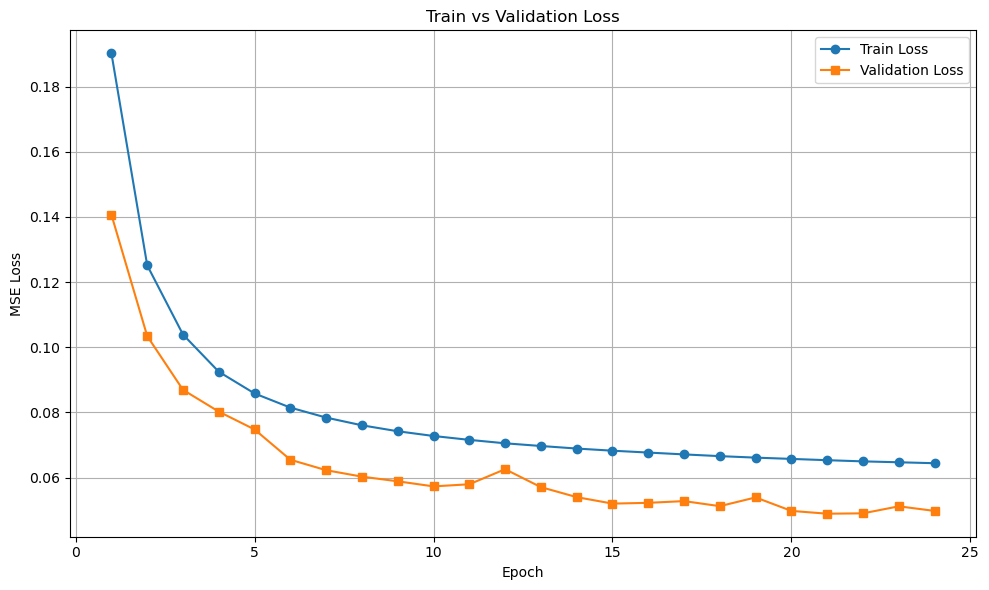

In [25]:

plt.figure(figsize=(10,6))

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses,   label="Validation Loss", marker='s')

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss")
plt.grid(True)
plt.legend()
plt.savefig('Train_vs_Validation_Loss_Mercosur.png', dpi=300)
plt.tight_layout()
plt.show()


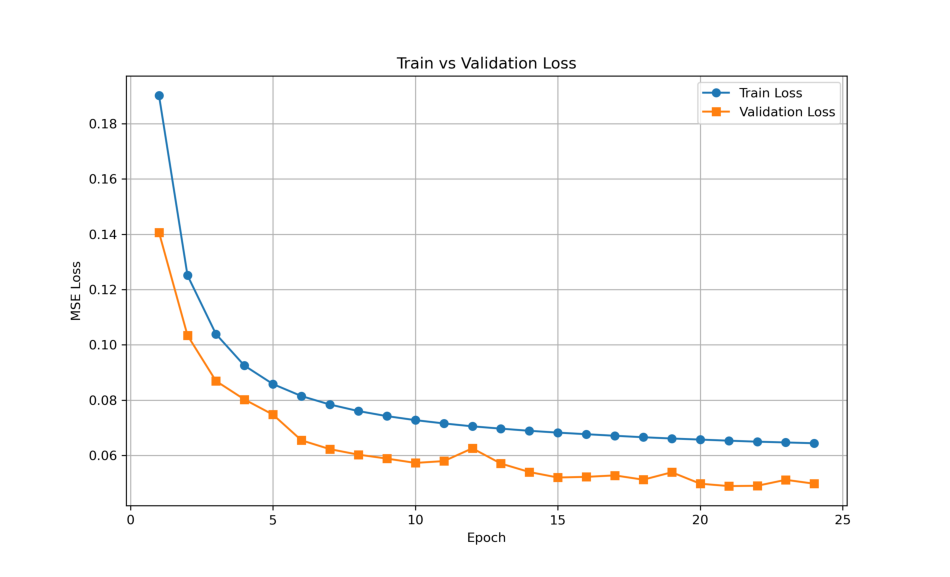

In [26]:
img = mpimg.imread("Train_vs_Validation_Loss_Mercosur.png")

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

lire les images de le training up side

In [28]:
capteur_model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)

        # forward no modelo
        y_pred = capteur_model(X_batch)  # (batch, seq_len, n_outputs)

        # manda tudo pra CPU e acumula
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(y_pred.cpu().numpy())

# junta todos os batches
y_true_scaled = np.concatenate(y_true_list, axis=0)  # (N, T, D)
y_pred_scaled = np.concatenate(y_pred_list, axis=0)  # (N, T, D)

# achata a dimensão temporal pra usar no scaler (espera 2D)
N, T, D = y_pred_scaled.shape

y_true_scaled_2d = y_true_scaled.reshape(-1, D)  # (N*T, D)
y_pred_scaled_2d = y_pred_scaled.reshape(-1, D)  # (N*T, D)

# volta pro espaço real
y_true_real = scaler_y.inverse_transform(y_true_scaled_2d)
y_pred_real = scaler_y.inverse_transform(y_pred_scaled_2d)

# métricas globais
mae_global  = mean_absolute_error(y_true_real, y_pred_real)
rmse_global = mean_squared_error(y_true_real, y_pred_real, squared=False)
r2_global   = r2_score(y_true_real, y_pred_real)

print("Overall metrics in the test set:")
print(f"MAE  : {mae_global:.4f}")
print(f"RMSE : {rmse_global:.4f}")
print(f"R²   : {r2_global:.4f}")

Overall metrics in the test set:
MAE  : 20.5281
RMSE : 34.9109
R²   : 0.9500


In [33]:
T = y_pred_scaled.shape[1]
N_seq_pred = y_pred_scaled.shape[0]

ids_test_eff = ids_test[:N_seq_pred]
ids_test_step = np.repeat(ids_test_eff, T)

metrics_per_flight = {}
unique_flights = np.unique(ids_test_eff)

for flight in unique_flights:
    mask = (ids_test_step == flight)

    y_true_f = y_true_real[mask]
    y_pred_f = y_pred_real[mask]

    mae  = mean_absolute_error(y_true_f, y_pred_f)
    rmse = mean_squared_error(y_true_f, y_pred_f, squared=False)
    r2   = r2_score(y_true_f, y_pred_f)

    metrics_per_flight[flight] = {"MAE": mae, "RMSE": rmse, "R2": r2}


In [ ]:
capteur_model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)

        # forward no modelo
        y_pred = capteur_model(X_batch)  # (batch, seq_len, n_outputs)

        # manda tudo pra CPU e acumula
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(y_pred.cpu().numpy())

# junta todos os batches
y_true_scaled = np.concatenate(y_true_list, axis=0)  # (N, T, D)
y_pred_scaled = np.concatenate(y_pred_list, axis=0)  # (N, T, D)

# achata a dimensão temporal pra usar no scaler (espera 2D)
N, T, D = y_pred_scaled.shape

y_true_scaled_2d = y_true_scaled.reshape(-1, D)  # (N*T, D)
y_pred_scaled_2d = y_pred_scaled.reshape(-1, D)  # (N*T, D)

# volta pro espaço real
y_true_real = scaler_y.inverse_transform(y_true_scaled_2d)
y_pred_real = scaler_y.inverse_transform(y_pred_scaled_2d)

# métricas globais
mae_global  = mean_absolute_error(y_true_real, y_pred_real)
rmse_global = mean_squared_error(y_true_real, y_pred_real, squared=False)
r2_global   = r2_score(y_true_real, y_pred_real)

print("Overall metrics in the test set:")
print(f"MAE  : {mae_global:.4f}")
print(f"RMSE : {rmse_global:.4f}")
print(f"R²   : {r2_global:.4f}")

Overall metrics in the test set:
MAE  : 20.5281
RMSE : 34.9109
R²   : 0.9500


In [34]:
df_flights = pd.DataFrame.from_dict(metrics_per_flight, orient='index')

# adicionar as métricas globais
df_global = pd.DataFrame({
    "MAE":  [mae_global],
    "RMSE": [rmse_global],
    "R2":   [r2_global]
}, index=["GLOBAL"])

# concatenar tudo
df_results = pd.concat([df_flights, df_global])



In [37]:
df_results.to_csv('df_results_multi_model.csv')

In [36]:
# df_results = pd.read_csv('df_results_all.csv')
df_results


,MAE,RMSE,R2
TOL_1,21.411116,35.396049,0.950829
TOL_10,21.469473,35.473278,0.949585
TOL_11,21.668261,35.956020,0.948748
TOL_12,21.871603,36.244915,0.948428
TOL_13,21.405066,35.142048,0.950851
TOL_14,21.944002,36.332851,0.948736
TOL_15,21.899666,36.122211,0.949418
TOL_17,21.490608,35.413269,0.950260
TOL_18,21.938776,36.316383,0.948756
TOL_19,21.660200,36.023014,0.948947
